In [ ]:
import os
import json
import warnings
import re
import html

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

import umap
import hdbscan

from tqdm import tqdm
from itertools import product

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

warnings.filterwarnings("ignore")


# Data 

On concatene toute la data que l'on a traité pour l'instant : textes, features et images

In [151]:

photos = pd.read_csv('embeddings_images.csv')
texte=pd.read_csv("restaurants_embeddings_reviews.csv")
features=pd.read_csv("features.csv")
photos.rename(columns={'gbusiness_id':'business_id'}, inplace=True)
df=pd.merge(photos, features, on='business_id', how='outer')
df.rename(columns={'embedding':'image_embedding'}, inplace=True)
df=pd.merge(df, texte, on='business_id', how='outer')
df.rename(columns={'embedding':'texte_embedding'}, inplace=True)

In [152]:
data = []
with open("data/philly_restaurant_reviews.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))
texte_original = pd.DataFrame(data)

# nombre d'avis par business
textes_40 = (
    texte_original
    .sort_values("date", ascending=False)   # du plus récent au plus ancien
    .groupby("business_id")
    .head(40)                                # garder les 40 plus récents
    .groupby("business_id")["text"]
    .apply(lambda x: " ".join(x))            # concatener les textes
    .reset_index()
)

In [153]:
df=pd.merge(df, textes_40, on='business_id', how='outer')

In [154]:
df

business_id  \
0     -0M0b-XhtFagyLmsBtOe8w   
1     -0PN_KFPtbnLQZEeb23XiA   
2     -0TffRSXXIlBYVbb5AwfTg   
3     -0eUa8TsXFFy0FCxHYmrjg   
4     -1B9pP_CrRBJYPICE5WbRA   
...                      ...   
5847  zxY4DgtXsVHihSUpsmwamg   
5848  zy7uNOvpykrq-XlmDY_wHA   
5849  zyMkbavgHASQtqVwaock9A   
5850  zz-fcqurtm77bZ_rVvo2Lw   
5851  zzyx5x0Z7xXWWvWnZFuxlQ   

                                        image_embedding  n_labels  \
0     [ 9.81536725e-03 -1.35909736e-03  1.12843779e-...       1.0   
1                                                   NaN       NaN   
2     [-2.06359725e-03  2.78890153e-02  9.09338878e-...       4.0   
3     [ 3.80490937e-02 -7.54836206e-04  8.75527248e-...       1.0   
4     [-2.49907263e-02  3.30465585e-02  3.43133989e-...       2.0   
...                                                 ...       ...   
5847                                                NaN       NaN   
5848                                                NaN       NaN   
5849                                                NaN       NaN   
5850  [ 3.73759915e-02  5.26558618e-02 -2.25258733e-...       1.0   
5851  [-6.21325854e-03  4.38203387e-02  9.31397059e-...       1.0   

                    labels_present  review_count  log_review_count     stars  \
0                           inside            18          2.944439  3.722222   
1                              NaN            11          2.484907  3.363636   
2     drink, food, inside, outside          1132          7.032624  4.355124   
3                             food            28          3.367296  3.964286   
4                     food, inside           851          6.747587  3.808461   
...                            ...           ...               ...       ...   
5847                           NaN             6          1.945910  4.333333   
5848                           NaN             6          1.945910  3.166667   
5849                           NaN            21          3.091042  3.809524   
5850                          food            25          3.258097  4.480000   
5851                          food             8          2.197225  2.500000   

      rating_std  positive_ratio  negative_ratio  ...  review_growth_rate  \
0       0.894792        0.722222        0.055556  ...            0.000000   
1       1.361817        0.545455        0.181818  ...            0.000000   
2       0.983165        0.851590        0.066254  ...            0.041519   
3       1.070899        0.714286        0.142857  ...            0.000000   
4       1.205760        0.696827        0.150411  ...            0.014101   
...          ...             ...             ...  ...                 ...   
5847    0.516398        1.000000        0.000000  ...            0.000000   
5848    0.983192        0.500000        0.333333  ...            0.000000   
5849    0.928388        0.761905        0.142857  ...            0.000000   
5850    0.714143        0.880000        0.000000  ...            0.000000   
5851    0.925820        0.125000        0.500000  ...            0.000000   

      expert_reviewer_ratio  elite_reviewer_ratio  high_influence_ratio  \
0                  0.555556                   0.0              0.500000   
1                  0.272727                   0.0              0.181818   
2                  0.380742                   0.0              0.183746   
3                  0.392857                   0.0              0.107143   
4                  0.327850                   0.0              0.166863   
...                     ...                   ...                   ...   
5847               0.666667                   0.0              0.500000   
5848               0.500000                   0.0              0.500000   
5849               0.238095                   0.0              0.238095   
5850               0.600000                   0.0              0.440000   
5851               0.250000                   0.0              0.000000   

      mean_influ

On supprime les restaurants fermés (inutile pour nous) 

In [155]:
df = df[df['is_open'] != 0]
df = df.reset_index(drop=True)

Code pour convertir les embedding en array de XD (ils ont été condensé sur une colonne dans les fichiers csv)

In [157]:
import numpy as np
def convert_embeddings(embeddings_strings):

    embeddings_list = []
    embedding_dim = None
    
    #determiner dimension
    for emb_str in embeddings_strings:
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str != 'nan' and emb_str != 'None':
            try:
                emb_str_clean = emb_str.strip('[]')
                emb_array = np.fromstring(emb_str_clean, sep=' ')
                embedding_dim = len(emb_array)
                break
            except:
                continue

    #convertir tous les embeddings
    for i, emb_str in enumerate(embeddings_strings):
        
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str == 'nan' or emb_str == 'None':
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
            continue
        
        try:
            # Nettoyer la string et convertir en array
            emb_str_clean = emb_str.strip('[]')
            emb_array = np.fromstring(emb_str_clean, sep=' ')
            embeddings_list.append(emb_array)
        except Exception as e:
            # si y'a pas pour les photos par ex on remplace par NaN
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
    
    # Convertir en array
    embeddings_2d = np.array(embeddings_list)
    
   
    
    return embeddings_2d


In [158]:
image_embedding = convert_embeddings(df['image_embedding'].tolist())
texte_embedding=convert_embeddings(df['texte_embedding'].tolist())
features = df[['log_review_count', 'stars', 'rating_std', 'positive_ratio', 
               'negative_ratio',
               'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio', 
               'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score']]

# Clustering

Afin de procéder à la clusterisation, nous avons suivi les étapes suivantes :

- Réduction de dimension des embeddings textuels : les représentations textuelles étant de dimension très élevée, elles risqueraient d’écraser les features numériques. Nous appliquons donc une PCA en première étape. UMAP aurait pu être utilisée directement, mais elle est en pratique moins stable et moins performante sur des dimensions très élevées.

- Pondération texte / features numériques : nous introduisons un paramètre α permettant de contrôler l’importance relative du texte par rapport aux variables numériques. Grâce à α, il est possible de quantifier précisément la contribution de chaque modalité en fonction de leur dimension respective (le détail du calcul est présenté en annexe).

- Projection UMAP : l’espace combiné est ensuite projeté via UMAP, afin de réduire légèrement la dimension avant le clustering et de « dérouler » la réduction linéaire effectuée par la PCA, en capturant des structures non linéaires plus locales.

- lusterisation : enfin, nous appliquons HDBSCAN, un algorithme de clustering dense, bien adapté à des données hétérogènes et capable de gérer le bruit sans imposer un nombre de clusters a priori.

L’ensemble de ces choix méthodologiques s’appuie sur l’état de l’art, notamment les travaux de Zhou et al. (A Survey and an Empirical Evaluation of Multi-View Clustering Approaches) et de Grootendorst (BERTopic: Neural topic modeling with a class-based TF-IDF procedure).

Au départ, nous avons testé manuellement plusieurs combinaisons de paramètres, mais les résultats étaient instables et difficiles à comparer. Nous avons donc décidé de mettre en place une grid search sur les paramètres clés du pipeline :
pca_components, α, umap_n_components, umap_n_neighbors, min_cluster_size, min_samples et cluster_selection_method.

Les zones de recherche ont été définies de manière logique :

des valeurs de PCA suffisamment élevées pour conserver une grande partie de la variance,

un α plutôt bas, afin de ne pas donner un poids excessif aux embeddings textuels,

une dimension UMAP pas trop faible, pour préserver l’information dans un espace de données très dispersé,

des paramètres de clustering HDBSCAN standards, adaptés à la taille et à l’hétérogénéité des variables.

Afin de structurer l’analyse des résultats, nous avons ensuite défini un score indicatif. Ce score attribue des points lorsque certains critères sont respectés (par exemple un taux d’outliers inférieur à une cible ou une silhouette moyenne au-dessus d’un seuil) et pénalise les clusters de faible qualité, notamment ceux présentant une silhouette faible.

In [ ]:
def grid_search(texte_embedding, features, 
                              target_outliers_pct=15,
                              min_clusters=5,
                              min_silhouette=0.25,
                              verbose=True):
    
    
    #Grille d'optimisation
    param_grid = {
        'pca_components': [50, 60, 70],
        'alpha': [0.3, 0.4, 0.5],
        'umap_n_components': [20, 25, 30],
        'umap_n_neighbors': [10, 15, 20],
        
        # HDBSCAN 
        'min_cluster_size': [30, 40, 50, 60], 
        'min_samples': [20, 30, 40, 50],      # Sensibilité au bruit (plus c'est haut, plus il y a d'outliers)
        'cluster_selection_method': ['eom', 'leaf'] # eom=global, leaf=plus précis
    }
    
    # Génération de toutes les combinaisons possibles
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = list(product(*values))
    
    #HDBSCAN impose que min_samples soit <= min_cluster_size
    valid_combinations = [
        combo for combo in combinations
        if dict(zip(keys, combo))['min_samples'] <= dict(zip(keys, combo))['min_cluster_size']
    ]
    
    n_total = len(valid_combinations)
    print(f"Testing {n_total} configurations...\n")
    
    results = []
    best_score = -np.inf
    best_params = None
    best_labels = None
    best_embedded = None
    best_details = None
    
    iterator = tqdm(valid_combinations, desc="Grid Search") if verbose else valid_combinations
    
    for combo in iterator:
        params = dict(zip(keys, combo))
        
        try:
            # reduction pca
            pca = PCA(n_components=params['pca_components'])
            text_reduced = pca.fit_transform(texte_embedding)
            
            # normalisations
            stats_scaled = RobustScaler().fit_transform(features)
            
            # on multiplie chaque matrice par son poids
            alpha = params['alpha']
            combined = np.concatenate([
                alpha * text_reduced,
                (1 - alpha) * stats_scaled
            ], axis=1)
            
            # projection umap
            reducer = umap.UMAP(
                n_components=params['umap_n_components'],
                n_neighbors=params['umap_n_neighbors'],
                min_dist=0.0,
                metric='euclidean',
                random_state=42,
                verbose=False
            )
            embedded = reducer.fit_transform(combined)
            
            # clustering
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=params['min_cluster_size'],
                min_samples=params['min_samples'],
                metric="euclidean",
                cluster_selection_method=params['cluster_selection_method']
            )
            labels = clusterer.fit_predict(embedded)
            
            # Calcul des metriques 
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_outliers = (labels == -1).sum()
            outlier_pct = n_outliers / len(labels) * 100
            
            # On ne calcule la silhouette que sur les points qui ne sont pas du bruit (-1)
            mask_clustered = labels != -1
            
            if mask_clustered.sum() > 0 and n_clusters > 1:
                # Score de cohésion globale
                silhouette_global = silhouette_score(
                    embedded[mask_clustered], 
                    labels[mask_clustered]
                )
                
                # Scores de silhouette pour chaque point individuel
                silhouette_vals = silhouette_samples(
                    embedded[mask_clustered],
                    labels[mask_clustered]
                )
                
                labels_clustered = labels[mask_clustered]
                
                # Analyse granulaire par cluster
                cluster_details = []
                min_cluster_silhouette = 1.0
                n_bad_clusters = 0  # Clusters avec silhouette négative (mauvais)
                n_weak_clusters = 0 # Clusters peu denses
                
                for cluster_id in set(labels_clustered):
                    mask = labels_clustered == cluster_id
                    cluster_size = mask.sum()
                    cluster_silhouette = silhouette_vals[mask].mean()
                    
                    cluster_details.append({
                        'id': cluster_id,
                        'size': cluster_size,
                        'silhouette': cluster_silhouette
                    })
                    
                    # Mise à jour du pire score de cluster trouvé
                    if cluster_silhouette < min_cluster_silhouette:
                        min_cluster_silhouette = cluster_silhouette
                    
                    # Identification des clusters problématiques
                    if cluster_silhouette < 0:
                        n_bad_clusters += 1
                    elif cluster_silhouette < 0.2:
                        n_weak_clusters += 1
                
                # Vérification de l'équilibre (éviter qu'un cluster mange tout le dataset)
                sizes = [c['size'] for c in cluster_details]
                largest_cluster_pct = max(sizes) / len(labels) * 100
                
                # Indice Davies-Bouldin (plus il est bas, mieux c'est)
                db_score = davies_bouldin_score(
                    embedded[mask_clustered],
                    labels_clustered
                )
            else:
                # Valeurs par défaut si le clustering a échoué
                silhouette_global = -1
                min_cluster_silhouette = -1
                n_bad_clusters = 999
                n_weak_clusters = 999
                db_score = 999
                cluster_details = []
                largest_cluster_pct = 100
            
            # --- LOGIQUE DU SCORING ---
            # On définit des critères de succès
            meets_outliers = abs(outlier_pct - target_outliers_pct) <= 7 # Proche de la cible
            meets_clusters = n_clusters >= min_clusters                 # Assez de groupes
            meets_silhouette = silhouette_global >= min_silhouette     # Qualité minimale
            no_terrible_clusters = n_bad_clusters == 0                  # Pas de cluster "mélangé"
            reasonable_balance = largest_cluster_pct < 40               # Répartition saine
            
            if (meets_outliers and meets_clusters and meets_silhouette and 
                no_terrible_clusters and reasonable_balance):
                # Formule de score si tout va bien (On récompense la silhouette et le nb de clusters)
                score = (
                    silhouette_global * 1000 +
                    min_cluster_silhouette * 200 +
                    n_clusters * 20 +
                    (1 - outlier_pct/100) * 100 -
                    n_weak_clusters * 50 -
                    abs(outlier_pct - target_outliers_pct) * 10
                )
            else:
                # Très fortes pénalités si un critère n'est pas rempli
                score = -1000
                if not meets_outliers:
                    score -= abs(outlier_pct - target_outliers_pct) * 20
                if not meets_clusters:
                    score -= (min_clusters - n_clusters) * 100
                if not meets_silhouette:
                    score -= (min_silhouette - silhouette_global) * 500
                if n_bad_clusters > 0:
                    score -= n_bad_clusters * 300
            
            # Sauvegarde du résultat de l'itération
            result = {
                **params,
                'n_clusters': n_clusters,
                'n_outliers': n_outliers,
                'outlier_pct': outlier_pct,
                'silhouette_global': silhouette_global,
                'score': score,
                'meets_all': (score > 0)
            }
            results.append(result)
            
            # Mise à jour du "Best" si le score dépasse le précédent
            if score > best_score:
                best_score = score
                best_params = params.copy()
                best_labels = labels.copy()
                best_embedded = embedded.copy()
                best_details = cluster_details.copy()
                
                if verbose:
                    tqdm.write(f"\n✨ Nouveau meilleur: score={score:.1f} ({n_clusters} clusters)")
        
        except Exception as e:
            if verbose:
                tqdm.write(f" Erreur: {e}")
            continue
            
    # Transformation des résultats en DataFrame pour analyse facile
    results_df = pd.DataFrame(results)
    return {
        'best_params': best_params,
        'best_labels': best_labels,
        'best_embedded': best_embedded,
        'best_details': best_details,
        'results_df': results_df,
        'best_score': best_score
    }

In [160]:




"""


#grid search 

results = grid_search(

texte_embedding=texte_embedding,

features=features,

target_outliers_pct=15,

min_clusters=6,

min_silhouette=0.25,

verbose=True

)



results['results_df'].to_csv('grid_search.csv', index=False)





"""

"\n\n\n#grid search \n\nresults = grid_search(\n\ntexte_embedding=texte_embedding,\n\nfeatures=features,\n\ntarget_outliers_pct=15,\n\nmin_clusters=6,\n\nmin_silhouette=0.25,\n\nverbose=True\n\n)\n\n\n\nresults['results_df'].to_csv('grid_search.csv', index=False)\n\n\n\n\n\n"

In [161]:
results=pd.read_csv("grid_search.csv")

In [162]:
results.head(30)

pca_components  alpha  umap_n_components  umap_n_neighbors  \
0               60    0.7                 25                10   
1               70    0.7                 25                10   
2               60    0.5                 30                10   
3               50    0.7                 20                10   
4               50    0.5                 25                10   
5               50    0.7                 30                10   
6               50    0.7                 25                10   
7               50    0.7                 25                10   
8               70    0.5                 25                10   
9               70    0.5                 30                10   
10              70    0.4                 20                10   
11              70    0.6                 30                10   
12              70    0.6                 20                10   
13              50    0.6                 25                15   
14              70    0.6                 30                15   
15              50    0.7                 20                15   
16              70    0.3                 30                10   
17              70    0.3                 25                10   
18              70    0.6                 20                20   
19              60    0.6                 20                15   
20              50    0.3                 30                10   
21              50    0.4                 30                10   
22              60    0.3                 20                10   
23              60    0.7                 20                20   
24              60    0.3                 30                10   
25              60    0.3                 20                10   
26              60    0.3                 20                15   
27              60    0.6                 30                10   
28              50    0.3                 30                10   
29              70    0.3                 25                10   

    min_cluster_size  min_samples cluster_selection_method  n_clusters  \
0                 50           20                      eom          14   
1                 60           20                      eom          14   
2                 60           20                      eom          14   
3                 60           20                      eom          13   
4                 60           20                      eom          13   
5                 60           30                      eom          11   
6                 60           20                      eom          13   
7                 50           30                      eom          12   
8                 60           20                      eom          13   
9                 60           20                      eom          13   
10                50           20                      eom          12   
11                60           40                      eom           5   
12                60           40                      eom           5   
13                60           50                      eom           5   
14                60           30                      eom           5   
15                60           20                      eom          12   
16                60           20                      eom          12   
17                60           20                      eom          12   
18                60           30                      eom           6   
19                60           30                      eom           6   
20                60           30                      eom           9   
21                60           20                      eom          10   
22                60           30                      eom          10   
23                60           20                      eom          13   
24                60           20                      eom          14   
25                60           20

Pour choisir la combinaison finale, nous ne retenons pas systématiquement la première de la liste. Nous avons d’abord cherché à privilégier l’équilibre entre les features numériques et le texte. Avec 50 dimensions textuelles, 11 features numériques et une valeur de α = 0,3, on obtient une contribution d’environ 50 % pour chaque modalité, ce qui correspond à un bon compromis (calcul détaillé en annexe).

Une fois cet équilibre assuré, le choix s’est fait en comparant les configurations restantes. Après plusieurs tests, la ligne 20 apparaît comme la plus satisfaisante, notamment en termes de taux d’outliers, de qualité de séparation des clusters (silhouette) et de stabilité globale.

(on ne relance pas pour eviter les petites variations)

In [163]:


# # 1. Réduire les embeddings texte
# pca = PCA(n_components=50)  
# text_reduced = pca.fit_transform(texte_embedding)
# print(f"Variance conservée: {pca.explained_variance_ratio_.sum():.1%}")
# 
# # 2. Normaliser
# text_scaled = StandardScaler().fit_transform(text_reduced)
# stats_scaled = RobustScaler().fit_transform(features)  # Robuste aux outliers
# 
# # 3. Combiner avec poids ajustable
# alpha = 0.3  
# combined = np.concatenate([
#     alpha * text_scaled,
#     (1 - alpha) * stats_scaled
# ], axis=1)
# 
# # 4. UMAP pour capturer les structures non-linéaires
# reducer = umap.UMAP(
#     n_components=30,
#     n_neighbors=10,
#     min_dist=0.0,
#     metric='euclidean',
#     random_state=42
# )
# embedded = reducer.fit_transform(combined)
# 
# # 5. HDBSCAN
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=60,
#     min_samples=30,
#     cluster_selection_epsilon=0.0
# )
# labels = clusterer.fit_predict(embedded)
# 
# # 6. Analyser
# n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
# n_noise = (labels == -1).sum()
# print(f"Clusters: {n_clusters}, Bruit: {n_noise}/{len(labels)}")


On cree une fonction pour analyser nos clusters. Elle sert principalement d’outil d’aide au choix du modèle de clustering. Elle permet de comparer différentes configurations en évaluant rapidement le nombre de clusters, la proportion d’outliers, l’équilibre des tailles et la qualité de séparation (silhouette et Davies-Bouldin lorsque disponibles).

L’objectif n’est pas seulement d’obtenir de “bons” scores, mais d’identifier une configuration stable et interprétable.

In [ ]:

def analyze_clusters(labels, embedded=None, stats_scaled=None):

    #Comptage de base
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_outliers = (labels == -1).sum()
    n_total = len(labels)

    print(f"  Total de points      : {n_total}")
    print(f"  Nombre de clusters   : {n_clusters}")
    print(f"  Outliers            : {n_outliers} ({n_outliers/n_total*100:.1f}%)")
    print(f"  Points clusterisés   : {n_total - n_outliers} ({(n_total-n_outliers)/n_total*100:.1f}%)")
    
    # Distribution des tailles
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    
    print(f"{'Cluster ID':<15} {'Taille':<15} {'% du total':<15} ")

    
    for cluster_id in sorted(unique_labels):
        if cluster_id == -1:
            size = n_outliers
            pct = n_outliers / n_total * 100
            print(f"{'Outliers':<15} {size:<15} {pct:<14.1f}% ")
        else:
            size = cluster_sizes[cluster_id]
            pct = size / n_total * 100
            print(f"Cluster {cluster_id:<7} {size:<15} {pct:<14.1f}%")
    
    #Statistiques sur les tailles
    cluster_sizes_no_noise = cluster_sizes[cluster_sizes.index != -1]
    
    print(f"\ STATISTIQUES DES TAILLES (hors outliers):")
    print(f"  Plus petit cluster   : {cluster_sizes_no_noise.min()}")
    print(f"  Plus grand cluster   : {cluster_sizes_no_noise.max()}")
    print(f"  Taille moyenne       : {cluster_sizes_no_noise.mean():.0f}")
    print(f"  Taille médiane       : {cluster_sizes_no_noise.median():.0f}")
    print(f"  Écart-type          : {cluster_sizes_no_noise.std():.0f}")
    
    #Équilibre
    largest_cluster_pct = cluster_sizes_no_noise.max() / n_total * 100
    
    # Entropie de Shannon
    print(f"\nÉQUILIBRE:")
    if largest_cluster_pct > 50:
        print(f"  DÉSÉQUILIBRÉ: Le plus gros cluster contient {largest_cluster_pct:.1f}% des données")
        print(f"      → Considère augmenter min_cluster_size pour le subdiviser")
    elif largest_cluster_pct > 30:
        print(f"  MODÉRÉMENT DÉSÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    else:
        print(f"  ÉQUILIBRÉ: Le plus gros cluster = {largest_cluster_pct:.1f}%")
    
    # Qualité 
    if embedded is not None:
        print(f"\nQUALITÉ DES CLUSTERS:")
        from sklearn.metrics import silhouette_samples, davies_bouldin_score
        
        # Silhouette par cluster
        mask_clustered = labels != -1
        if mask_clustered.sum() > 0:
            silhouette_vals = silhouette_samples(embedded[mask_clustered], 
                                                labels[mask_clustered])
            
            print(f"\n  {'Cluster':<12} {'Taille':<12} {'Silhouette':<15} {'Qualité'}")
            print("  " + "-" * 60)
            
            labels_clustered = labels[mask_clustered]
            for cluster_id in sorted(set(labels_clustered)):
                mask = labels_clustered == cluster_id
                cluster_silhouette = silhouette_vals[mask].mean()
                size = mask.sum()
                
                if cluster_silhouette > 0.5:
                    quality = "tres bine"
                elif cluster_silhouette > 0.3:
                    quality = "Bon"
                elif cluster_silhouette > 0.1:
                    quality = "Moyen"
                else:
                    quality = "Faible"
                
                print(f"  Cluster {cluster_id:<4} {size:<12} {cluster_silhouette:<14.3f} {quality}")
            
            # Silhouette globale
            mean_silhouette = silhouette_vals.mean()
            print(f"\n  Silhouette moyenne globale: {mean_silhouette:.3f}")
            
            if mean_silhouette > 0.5:
                print(f"  tres bonne séparation des clusters")
            elif mean_silhouette > 0.3:
                print(f"  bonne séparation des clusters")
            elif mean_silhouette > 0.1:
                print(f"  Séparation moyenne")
            else:
                print(f" MAUVAISE séparation - structure peu claire")
            
            # Davies-Bouldin 
            if len(set(labels_clustered)) > 1:
                db_score = davies_bouldin_score(embedded[mask_clustered], 
                                               labels_clustered)
                print(f"  Davies-Bouldin Index: {db_score:.3f} (plus bas = mieux)")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution des tailles (barplot)
    ax1 = axes[0]
    cluster_ids = [c for c in cluster_sizes.index if c != -1]
    sizes = [cluster_sizes[c] for c in cluster_ids]
    
    bars = ax1.bar(range(len(cluster_ids)), sizes)
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Nombre de points')
    ax1.set_title(f'Distribution des tailles ({n_clusters} clusters)')
    ax1.set_xticks(range(len(cluster_ids)))
    ax1.set_xticklabels(cluster_ids)
    
 
    max_idx = sizes.index(max(sizes))
    bars[max_idx].set_color('red')
    bars[max_idx].set_alpha(0.7)
    

    ax1.axhline(y=n_outliers, color='black', linestyle='--', 
                label=f'Outliers ({n_outliers})', alpha=0.5)
    ax1.legend()
    
    ax2 = axes[1]
    
    # Top 5 clusters + outliers + autres
    top_5 = cluster_sizes_no_noise.nlargest(5)
    pie_data = list(top_5.values)
    pie_labels = [f'Cluster {i}' for i in top_5.index]
    
    if n_outliers > 0:
        pie_data.append(n_outliers)
        pie_labels.append('Outliers')
    
    others = n_total - sum(pie_data)
    if others > 0:
        pie_data.append(others)
        pie_labels.append(f'Autres ({n_clusters - 5} clusters)')
    
    ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Répartition des points')
    
    plt.tight_layout()
    plt.savefig('cluster_distribution.png', dpi=150, bbox_inches='tight')
    print(f"\n Graphiques sauvegardés: cluster_distribution.png")
    
    return {
        'n_clusters': n_clusters,
        'n_outliers': n_outliers,
        'cluster_sizes': cluster_sizes,
        'largest_cluster_pct': largest_cluster_pct
    }



In [165]:
# Suavegarde


#umap_cols = [f'umap_feat_{i}' for i in range(embedded.shape[1])]
#df_umap = pd.DataFrame(embedded, columns=umap_cols, index=df.index)
#df_final = pd.concat([df, df_umap], axis=1)
#df_final['cluster_label'] = labels
#df_final.to_csv('resultats_clustering_complet.csv', index=False)


ANALYSE DES CLUSTERS

RÉSUMÉ GÉNÉRAL:
  Total de points      : 3525
  Nombre de clusters   : 9
  Outliers            : 994 (28.2%)
  Points clusterisés   : 2531 (71.8%)

 TAILLE DES CLUSTERS:
Cluster ID      Taille          % du total      
Outliers        994             28.2          % 
Cluster 0       97              2.8           %
Cluster 1       805             22.8          %
Cluster 2       276             7.8           %
Cluster 3       191             5.4           %
Cluster 4       77              2.2           %
Cluster 5       73              2.1           %
Cluster 6       133             3.8           %
Cluster 7       556             15.8          %
Cluster 8       323             9.2           %
\ STATISTIQUES DES TAILLES (hors outliers):
  Plus petit cluster   : 73
  Plus grand cluster   : 805
  Taille moyenne       : 281
  Taille médiane       : 191
  Écart-type          : 250

ÉQUILIBRE:
  ÉQUILIBRÉ: Le plus gros cluster = 22.8%

QUALITÉ DES CLUSTERS:

  Cluster    

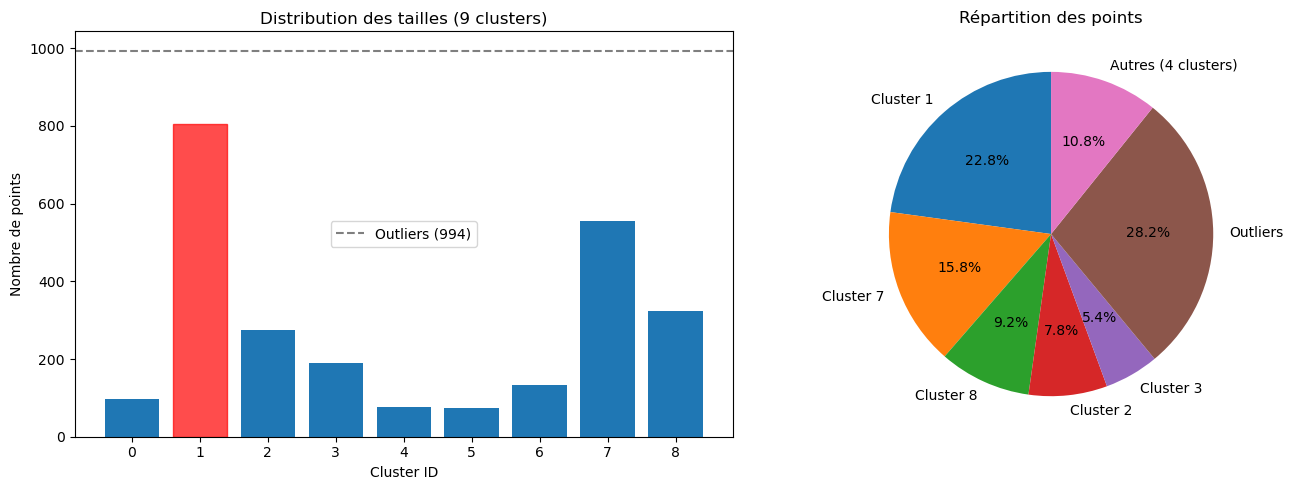

In [187]:
df_load = pd.read_csv('resultats_clustering_complet.csv')
cols_to_use = [c for c in df_load.columns if c.startswith('umap_feat_')]
embedded_from_csv = df_load[cols_to_use].values
labels_from_csv = df_load['cluster_label'].values

stats = analyze_clusters(labels_from_csv, embedded=embedded_from_csv)

In [167]:
df_load.columns.tolist()

['business_id',
 'image_embedding',
 'n_labels',
 'labels_present',
 'review_count',
 'log_review_count',
 'stars',
 'rating_std',
 'positive_ratio',
 'negative_ratio',
 'photo_count',
 'log_photo_count',
 'business_age_years',
 'review_growth_rate',
 'expert_reviewer_ratio',
 'elite_reviewer_ratio',
 'high_influence_ratio',
 'mean_influence_score',
 'is_open',
 'texte_embedding',
 'n_reviews',
 'umap_feat_0',
 'umap_feat_1',
 'umap_feat_2',
 'umap_feat_3',
 'umap_feat_4',
 'umap_feat_5',
 'umap_feat_6',
 'umap_feat_7',
 'umap_feat_8',
 'umap_feat_9',
 'umap_feat_10',
 'umap_feat_11',
 'umap_feat_12',
 'umap_feat_13',
 'umap_feat_14',
 'umap_feat_15',
 'umap_feat_16',
 'umap_feat_17',
 'umap_feat_18',
 'umap_feat_19',
 'umap_feat_20',
 'umap_feat_21',
 'umap_feat_22',
 'umap_feat_23',
 'umap_feat_24',
 'umap_feat_25',
 'umap_feat_26',
 'umap_feat_27',
 'umap_feat_28',
 'umap_feat_29',
 'cluster_label']

Avec une silhouette moyenne de 0,528 et un indice de Davies–Bouldin de 0,650, le clustering est statistiquement valide. Ces valeurs indiquent un bon compromis entre cohésion intra-cluster et séparation inter-clusters.

Le modèle identifie 9 clusters, un nombre raisonnable : ni trop élevé (ce qui nuirait à l’interprétabilité), ni trop faible pour capturer des labels métiers pertinents.

La silhouette globale (0,528) montre que les frontières entre les groupes sont bien définies. En particulier, les clusters 0, 4, 5 et 6 affichent des scores supérieurs à 0,80, ce qui signifie géométriquement qu’ils forment des îlots très denses et homogènes, donc fortement distinctifs.

Le cluster 1, bien que représentant 22,8 % des données, conserve une cohésion élevée (0,526). Il constitue le cœur du dataset : c’est le plus gros cluster, tout en restant équilibré. La structure globale est variée, allant de petites niches très spécifiques (73 points) à des segments de masse (jusqu’à 805 points).

Le taux d’outliers atteint 28,2 % (994 points). Il est élevé, mais ce choix est assumé : nous privilégions des clusters solides et bien séparés. La réduction de ces outliers sera étudiée dans un second temps.

Enfin, l’indice de Davies–Bouldin (0,650) confirme la qualité globale du modèle : les clusters sont bien espacés les uns des autres et la dispersion intra-cluster reste limitée.

# Interpretation des clusters

Afin d'analyser les clusters nous allons passer par deux etapes :
- Analyser les avis à l'interieur des clusters 
- Anlayser les statistiques descriptives pour chaque cluster

## Avis

Pour analyser les avis à l'intérieur des clusters, nous utilisons la méthode c-TF-IDF. L'idée est que plus un mot apparaît dans un cluster, plus son score est élevé. Pour cela, on calcule la fréquence d'apparition d'un mot dans le cluster, puis on pondère par sa fréquence dans l'ensemble des documents. Si un mot apparaît beaucoup dans tous les documents, on baisse son score pour ne garder que les mots vraiment caractéristiques de chaque cluster.



In [168]:
df_load = pd.merge(df_load, df[['business_id', 'text', 'cluster_ambiance']], on='business_id', how='left')

In [ ]:

# stopwords
stop_words = set(stopwords.words('english'))

# Initialiser le stemmer
stemmer = PorterStemmer()

# Fonction de nettoyage
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Nettoyage basique
    text = html.unescape(text)  
    text = text.lower()  
    text = re.sub(r"http\S+|www\S+", " ", text)  
    text = re.sub(r"<.*?>", " ", text) 
    text = re.sub(r"[^a-z\s]", " ", text)  
    text = re.sub(r"\s+", " ", text)  
    
    # Filtrage stopwords (garder mots 3+ caractères)
    filtered_tokens = [
        tok for tok in text.split()
        if tok not in stop_words and len(tok) > 2
    ]
    
    # Appliquer le stemming sur les mots filtrés
    stemmed_tokens = [
        stemmer.stem(tok)
        for tok in filtered_tokens
    ]
    
    return " ".join(stemmed_tokens)
df_load['text_cleaned'] = df_load['text'].apply(clean_text)

# Filtrer les outliers
df_no_outliers = df_load[df_load['cluster_label'] != -1].copy()

# Grouper les documents par cluster
docs_per_cluster = df_no_outliers.groupby('cluster_label')['text_cleaned'].apply(
    lambda x: " ".join(x)
)

# Créer le vectorizer
vectorizer = CountVectorizer(
    min_df=5,                      # Ignore mots dans <5 restaurants
    ngram_range=(1, 2),            # Unigrammes + bigrammes
    token_pattern=r'\b[a-z]{3,}\b' # Minimum 3 lettres
)

# Créer matrice terme-document 
X = vectorizer.fit_transform(docs_per_cluster.values)
tf = X.toarray()           # Matrice terme-fréquence
tf_sum = tf.sum(axis=0)    # Somme des occurrences par terme
A = tf.sum(axis=1).mean()  # Nombre moyen de mots par cluster

# Formule c-TF-IDF
ctfidf = tf * np.log(1 + A / tf_sum)

# Récupérer les noms des termes
terms = vectorizer.get_feature_names_out()

print(f"Vocabulaire: {len(terms)} termes")

# Extraire les top mots
top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]

# Affichage des résultats
print("TOP MOTS PAR CLUSTER (hors outliers)")


for cluster_id in sorted(docs_per_cluster.index):
    n_docs = (df_no_outliers['cluster_label'] == cluster_id).sum()
    
    print(f"\nCluster {cluster_id} ({n_docs} restaurants)")
    
    if cluster_id in top_words:
        for i, (word, score) in enumerate(top_words[cluster_id], 1):
            print(f"  {i:2d}. {word:<25} {score:8.3f}")

Vocabulaire: 55335 termes
TOP MOTS PAR CLUSTER (hors outliers)

Cluster 0 (97 restaurants)
   1. sushi                     16554.556
   2. roll                      11829.849
   3. ramen                     7017.184
   4. order                     5744.282
   5. place                     5329.155
   6. good                      4836.384
   7. fresh                     4139.025
   8. food                      4130.515
   9. great                     3991.041
  10. spici                     3832.009

Cluster 1 (805 restaurants)
   1. pizza                     57230.127
   2. order                     47199.797
   3. food                      31328.803
   4. place                     25545.421
   5. good                      24286.825
   6. time                      22954.007
   7. get                       19786.715
   8. chees                     19676.413
   9. chicken                   19628.642
  10. like                      18959.334

Cluster 2 (276 restaurants)
   1. food         

On a quand meme une separation par restaurants

Cluster 0 : Restaurants japonais avec des produits frais et épicés.

Cluster 1 : Pizzerias et restaurants de poulet frit proposant des commandes à emporter 

Cluster 2 : Restaurants chinois servant du poulet, du riz, des soupes et des nouilles.

Cluster 3 : Restaurants généralistes offrant une cuisine variée de bonne qualité, souvent essayée par les clients.

Cluster 4 : Restaurants italiens proposant des pâtes dans un cadre où le service est important.

Cluster 5 : Cafés et coffee shops servant des lattés et proposant un espace de travail agréable.

Cluster 6 : Restaurants mexicains spécialisés en tacos, burritos et salsa.

Cluster 7 : Bars et restaurants avec une ambiance sociale centrée sur les boissons et le service.

Cluster 8 : Établissements de petit-déjeuner et sandwicheries proposant de la nourriture rapide et pratique.

Comme nous le pensions, étant donné que nous travaillons avec des restaurants, ce qui est ressorti était une séparation par type de nourriture. Ce résultat est assez normal étant donné notre domaine, mais ne repond pas completement a notre question.

Pourtant, nous avons utilisé SBERT pour l'embedding des avis, qui analyse très finement les différentes "couches" d'interprétation (sentiment, service, ambiance), et HDBSCAN qui capture des relations complexes entre les clusters (pas seulement circulaires comme le ferait un K-means). 

Nous nous sommes donc demandé : et si nous filtrons uniquement sur les mots qui nous intéressent, c'est-à-dire les mots en lien avec l'ambiance, le service et l'expérience client, ne pourrions-nous pas obtenir quelque chose de plus intéressant ?
Nous avons donc mis en place une whitelist contenant uniquement les mots qui nous intéressent (service, staff, atmosphere, wait, order, etc.). Cette approche nous permet d'exploiter pleinement la richesse sémantique capturée par SBERT et HDBSCAN, tout en révélant des profils de restaurants basés sur l'expérience client plutôt que sur le type de cuisine.

In [170]:

ambiance = {
    # Service
    "service", "servic", "server", "waiter", "waitress", "staff", "barista",
    "friendly", "friendli", "rude", "attentive", "attent", "helpful", "professional",
    "quick", "fast", "slow", "efficient", "prompt",
    
    # Ambiance/Atmosphère
    "atmosphere", "atmospher", "ambiance", "vibe", "mood", "feel", "feeling",
    "cozy", "romantic", "casual", "fancy", "upscale", "elegant", "modern",
    "rustic", "authentic", "traditional", "contemporary",
    
    # Environnement physique
    "clean", "dirty", "messy", "spotless", "hygiene", "hygienic",
    "decor", "decoration", "interior", "design", "lighting",
    "comfortable", "comfortabl", "uncomfortable", "cramped", "spacious", "roomy",
    "loud", "noisy", "quiet", "peaceful", "crowded", "busy", "empty",
    
    # Attente/Timing
    "wait", "waiting", "waited", "reservation", "reserv", "seat", "seated",
    "table", "tabl", "queue", "line", "delay", "delayed",
    
    # Propreté/Organisation
    "organized", "organis", "chaotic", "messy", "tidy", "neat",
    
    # Expérience client
    "welcome", "welcom", "greeting", "greet", "hospitality", "host",
    "custom", "customer", "experience", "experi", "visit", "recommend", "return",
    
    # Prix/Valeur
    "price", "priced", "pricing", "expensive", "expens", "cheap", "affordable",
    "value", "worth", "worthwhile", "overpriced", "overpric", "reasonable", "reason",
    
    # Livraison/Commande
    "delivery", "deliveri", "takeout", "pickup", "order", "ordered",
    
    # Qualité générale 
    "fresh", "stale", "quality", "qualiti", "portion", "size", "generous", "small"
}

ambigu = {"price", "priced", "wait", "service", "staff", "atmosphere", 
                   "experience", "experi", "value"} 



On met en place les fonctions qui vont nous servir. Il y'a cerrtains mots qui sont parfois ambigu quand ils apparaissent dans le cluster. Par exemple quand on voit "price" on ne sait pas si ca veut dire trop cher ou pas assez cher. Pour cela nous allons mettre en place une fonction qui va recuperer les 5 mots avant et apres le mot ambigu et analyser sa polarité en focntion d'une liste predefinit. -1 si c'est negatif, +1 si c'est positif

In [ ]:

# Nettoyage des textes
def clean_for_ctfidf_whitelist(text: str) -> str:
  
    if not isinstance(text, str):
        return ""
    
    # Nettoyage basique
    text = html.unescape(text)  
    text = text.lower()  
    text = re.sub(r"http\S+|www\S+", " ", text)  
    text = re.sub(r"<.*?>", " ", text)  
    text = re.sub(r"[^a-z\s]", " ", text)  
    text = re.sub(r"\s+", " ", text)  
    
    # Filtrage whitelist 
    filtered_tokens = [
        tok for tok in text.split()
        if tok in ambiance and len(tok) > 2
    ]
    
    # stemming
    stemmed_tokens = [
        stemmer.stem(tok)
        for tok in filtered_tokens
    ]
    
    return " ".join(stemmed_tokens)



# analyse de polarité
def analyze_term_context(texts, term):
    
    positive_modifiers = {
        'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic',
        'reasonable', 'fair', 'worth', 'best', 'nice', 'friendly', 'love', 
        'loved', 'quick', 'fast', 'efficient', 'attentive', 'helpful', 
        'perfect', 'awesome'
    }

    negative_modifiers = {
        'bad', 'poor', 'terrible', 'awful', 'horrible', 'worst', 'never',
        'overpriced', 'expensive', 'high', 'unfair', 'rude', 'not',
        'slow', 'long', 'inattentive', 'unhelpful', 'disappointing', 
        'disappointed', 'lacking', 'mediocre', 'subpar', 'unprofessional'
    }
    
    pos_count = 0
    neg_count = 0
    contexts = []
    
    # Pour chaque texte du cluster
    for text in texts:
        if not isinstance(text, str):
            continue
        
        words = text.lower().split()
        
        # Chercher toutes les occurrences du terme à polariser
        for i, word in enumerate(words):
            if term in word:
                # Extraire fenêtre de contexte (5 mots avant et après)
                start = max(0, i - 5)
                end = min(len(words), i + 5 + 1)
                context_words = words[start:end]
                context = " ".join(context_words)
                
                contexts.append(context)
                
                # Compter modificateurs positifs/négatifs dans le contexte
                for cw in context_words:
                    if cw in positive_modifiers:
                        pos_count += 1
                    elif cw in negative_modifiers:
                        neg_count += 1
    
    # Déterminer polarité globale (seuil à 1.5x pour éviter faux positifs)
    if pos_count + neg_count == 0:
        polarity = "neutral"
    elif pos_count > neg_count * 1.5:
        polarity = "positive"
    elif neg_count > pos_count * 1.5:
        polarity = "negative"
    else:
        polarity = "mixed"
    
    return {
        'term': term,
        'polarity': polarity,
        'positive_contexts': pos_count,
        'negative_contexts': neg_count,
        'total_mentions': len(contexts),
        'sample_contexts': contexts[:3]  
    }


def analyze_ambiguous_terms(df, cluster_id, top_terms):
    results = {}
    
    # Récupérer tous les textes du cluster
    cluster_texts = df[df['cluster_label'] == cluster_id]['text'].tolist()
    
    # Analyser uniquement les termes ambigus présents dans les top terms
    for term in top_terms:
        if term.lower() in ambigu:
            results[term] = analyze_term_context(cluster_texts, term)
    
    return results


# top termes c-TF-IDF
def get_top_ctfidf_terms_per_cluster(ctfidf_matrix, feature_names, n_terms=10):
    top_terms_per_cluster = {}
    
    for cluster_id in range(ctfidf_matrix.shape[0]):
        # Récupérer les indices des N meilleurs scores 
        top_indices = ctfidf_matrix[cluster_id].argsort()[-n_terms:][::-1]
        
        # Convertir indices en noms de termes
        top_terms = [feature_names[i] for i in top_indices]
        
        top_terms_per_cluster[cluster_id] = top_terms
    
    return top_terms_per_cluster

On lance l'analyse

In [ ]:
# Appliquer le nettoyage avec whitelist sur la colonne 'text'
df_load["cleaned_text_ctfidf"] = df_load["text"].apply(clean_for_ctfidf_whitelist)
print(f"Documents avec contenu: {(df_load['cleaned_text_ctfidf'].str.len() > 0).sum()}/{len(df_load)}")

# Filtrer les outliers 
df_no_outliers = df_load[df_load['cluster_label'] != -1].copy()

# Grouper les textes nettoyés par cluster (sans -1)
docs_per_cluster = df_no_outliers.groupby('cluster_label')['cleaned_text_ctfidf'].apply(' '.join)

print(f"Clusters à analyser: {len(docs_per_cluster)}")

vectorizer = CountVectorizer(
    min_df=5,                      # Ignore mots dans <5 restaurants
    ngram_range=(1, 2),            # Unigrammes + bigrammes
    token_pattern=r'\b[a-z]{3,}\b' # Minimum 3 lettres
)

# Créer matrice terme-document 
X = vectorizer.fit_transform(docs_per_cluster.values)
tf = X.toarray()           # Matrice terme-fréquence
tf_sum = tf.sum(axis=0)    # Somme des occurrences par terme
A = tf.sum(axis=1).mean()  # Nombre moyen de mots par cluster

# Formule c-TF-IDF
ctfidf = tf * np.log(1 + A / tf_sum)

# Récupérer les noms des termes
terms = vectorizer.get_feature_names_out()

print(f"Vocabulaire: {len(terms)} termes")
top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]




print("TOP MOTS PAR CLUSTER ")
for cluster_id in sorted(docs_per_cluster.index):
    n_docs = (df_no_outliers['cluster_label'] == cluster_id).sum()
    
    print(f"\nCluster {cluster_id} ({n_docs} restaurants)")
    
    if cluster_id in top_words:
        for i, (word, score) in enumerate(top_words[cluster_id], 1):
            print(f"  {i:2d}. {word:<25} {score:8.3f}")



print("ANALYSE DE POLARITÉ DES TERMES AMBIGUS")

for cluster_id in sorted(docs_per_cluster.index):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Nombre de restaurants: {(df_no_outliers['cluster_label'] == cluster_id).sum()}")
    
    if cluster_id in top_words:
        # Extraire les termes pour analyse de polarité
        top_terms = [word for word, score in top_words[cluster_id]]
        
        # Analyser la polarité des termes ambigus
        ambiguous_analysis = analyze_ambiguous_terms(df_no_outliers, cluster_id, top_terms)
        
        if ambiguous_analysis:
            print(f"\nPolarité des termes ambigus:")
            for term, analysis in ambiguous_analysis.items():
                print(f"  {term}: {analysis['polarity']} "
                      f"(+{analysis['positive_contexts']} / "
                      f"-{analysis['negative_contexts']}) "
                      f"[{analysis['total_mentions']} mentions]")
                
                # Afficher un exemple de contexte
                if analysis['sample_contexts']:
                    print(f"    Exemple: '{analysis['sample_contexts'][0][:80]}...'")

Documents avec contenu: 3525/3525
Clusters à analyser: 9
Vocabulaire: 2733 termes
TOP MOTS PAR CLUSTER (hors outliers)

Cluster 0 (97 restaurants)
   1. fresh                     1924.595
   2. order                     1635.163
   3. qualiti                   1225.158
   4. price                     1220.123
   5. servic                    1155.649
   6. recommend                 1088.613
   7. experi                     871.758
   8. deliveri                   833.271
   9. takeout                    817.006
  10. order order                801.207

Cluster 1 (805 restaurants)
   1. order                     13234.348
   2. order order               10368.182
   3. deliveri                  7993.714
   4. servic                    5735.445
   5. custom                    5675.113
   6. wait                      5610.544
   7. order deliveri            4552.306
   8. custom servic             4467.573
   9. deliveri order            3962.968
  10. rude                      3657.939

C

- Cluster 0 : 

Restaurants premium avec forte satisfaction client sur tous les aspects. La qualité et la fraîcheur sont reconus et le rapport qualité-prix est tres bon.

- Cluster 1 :

Tres gros cluster avec service client catastrophique. C'est le seul cluster avec une polarité negative sur le temps d'attente. On mentionne egalement "rude".  "order delivery", "customer service", "delivery order" = problèmes récurrents de commandes


- Cluster 2 :

Prix : positif (+651/-246) - bon rapport qualité-prix
on retrouve pas mal de vocalbulaire sur le fait de prendre a emporter, des produits de qualité (fresh, authentic) et tres rapide.


- Cluster 3 :

Staff : très positif (+441/-49) - ratio 9:1
Wait : positif (+197/-106) - les clients acceptent d'attendre 
Expérience : positive (+226/-102)
Petits restaurants surement independants ("small" dans top 10) où le personnel fait la différence. L'attente positive suggère que l'expérience vaut le coup. Forte fidélisation client (recommend élevé).
 
- Cluster 4 : 

Segment haut de gamme avec service à table ect
"Table" et "reservation" indiquent service formel. Tous les indicateurs positifs = expérience ok de bout en bout. Clientèle qui réserve et valorise l'expérience complète.

- Cluster 5 :

Coffee shops avec forte identité sociale
Top termes: friendly, staff, barista, service, line, atmosphere, "staff friendly", "friendly staff"
Seul cluster avec "barista" = cafés spécialisés. Les bigrammes "staff friendly" / "friendly staff" montrent l'importance du personnel. "Line" suggère popularité (files d'attente). Atmosphère comme différenciateur.

- Cluster 6 : 

Restaurants traditionnels avec authenticité forte mais service variable
Polarité :
- Wait : mixte (+153/-132) - divisé
- Staff : positif (+355/-65)
- Prix : positif (+362/-159)

"Authentic" en position 2 = le coeur du cluster. "Worth" suggère que malgré l'attente (mixte), l'expérience en vaut la peine. Authenticité prime sur l'efficacité du service. Clientèle tolérante si authenticité au rendez-vous.

- Cluster 7 : 

2e plus grand cluster - un peu difficile de le classer mais on a vu plus haut que c'etait les bar surtout
Expérience : mixte (+1156/-800) - polarisant !
Staff : positif (+1891/-358)
Wait : mixte (+1095/-822)
Atmosphère : très positif (+1077/-90)

Expérience très polarisée = type de lieu qui "fait sensation" (on adore ou on déteste). Atmosphère exceptionnelle c' est le point fort. Attente mixte suggère flux variables

- Cluster 8 : 

Staff : positif (+976/-190)
Wait : mixte (+418/-306) - légèrement positif
Prix : positif (+921/-386)

"Quick" + "fast" en top suggere les fast food ca reprend ce que on a vu plus haut. Staff amical comme différenciateur face à la concurrence fast-food plus bad de gamme. Attente mixte malgré promesse de rapidité.



## Features numerique

On va maintenant passer à l'analyse des features numeriques

In [173]:
df_load.columns

Index(['business_id', 'image_embedding', 'n_labels', 'labels_present',
       'review_count', 'log_review_count', 'stars', 'rating_std',
       'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
       'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
       'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score',
       'is_open', 'texte_embedding', 'n_reviews', 'umap_feat_0', 'umap_feat_1',
       'umap_feat_2', 'umap_feat_3', 'umap_feat_4', 'umap_feat_5',
       'umap_feat_6', 'umap_feat_7', 'umap_feat_8', 'umap_feat_9',
       'umap_feat_10', 'umap_feat_11', 'umap_feat_12', 'umap_feat_13',
       'umap_feat_14', 'umap_feat_15', 'umap_feat_16', 'umap_feat_17',
       'umap_feat_18', 'umap_feat_19', 'umap_feat_20', 'umap_feat_21',
       'umap_feat_22', 'umap_feat_23', 'umap_feat_24', 'umap_feat_25',
       'umap_feat_26', 'umap_feat_27', 'umap_feat_28', 'umap_feat_29',
       'cluster_label', 'text', 'cluster_ambiance', 'text_clea

In [174]:

# Variables à analyser
stats_vars = [
    'n_labels', 'review_count', 'log_review_count', 'stars', 'rating_std',
    'positive_ratio', 'negative_ratio', 'photo_count', 'log_photo_count',
    'business_age_years', 'review_growth_rate', 'expert_reviewer_ratio',
    'elite_reviewer_ratio', 'high_influence_ratio', 'mean_influence_score'
]

# Pour chaque cluster
for cluster_id in sorted(df_load['cluster_label'].unique()):
    if cluster_id == -1:  # Skip outliers si présents
        continue
    
    print(f" CLUSTER {cluster_id}")
    
    # Filtrer les données du cluster
    cluster_data = df_load[df_load['cluster_label'] == cluster_id]
    print(f"Nombre de restaurants: {len(cluster_data)}")
    
    # Statistiques descriptives
    stats = cluster_data[stats_vars].describe().T
    
    # Ajouter la médiane
    stats['median'] = cluster_data[stats_vars].median()
    
    # Réorganiser les colonnes
    stats = stats[['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
    
    print("\n" + stats.to_string())


# Comparaison entre clusters
print("COMPARAISON ENTRE CLUSTERS")

comparison = df_load.groupby('cluster_label')[stats_vars].agg(['mean', 'median'])
print(comparison.to_string())

 CLUSTER 0
Nombre de restaurants: 97

                       count        mean      median         std       min        25%         50%         75%          max
n_labels                82.0    2.134146    2.000000    1.003232  1.000000   1.000000    2.000000    3.000000     5.000000
review_count            97.0  232.659794  142.000000  317.952069  6.000000  51.000000  142.000000  234.000000  1943.000000
log_review_count        97.0    4.801124    4.962845    1.205041  1.945910   3.951244    4.962845    5.459586     7.572503
stars                   97.0    4.024464    4.056075    0.398276  3.100000   3.740426    4.056075    4.301965     4.762821
rating_std              97.0    1.161764    1.174079    0.228165  0.547723   1.015249    1.174079    1.295308     1.722478
positive_ratio          97.0    0.745589    0.762887    0.127436  0.350000   0.653061    0.762887    0.837992     1.000000
negative_ratio          97.0    0.142842    0.129204    0.085609  0.000000   0.076923    0.129204    

- Cluster 0 

4.02 étoiles - Excellente satisfaction
233 avis (médiane 142) - Visibilité solide
7.3 ans d'ancienneté - Établissements récents mais installés
5.1% de croissance - Dynamique positive
14.1 photos - Le plus visuel de tous les clusters

Profil clientèle :

74.6% d'avis positifs / 14.3% négatifs
31.5% d'experts reviewers
16.8% d'influenceurs

Restaurants premium récents avec forte satisfaction client, excellent rapport qualité-prix, et forte attractivité visuelle. 

- Cluster 1 :

2.87 étoiles - Pire note de tous les clusters
52 avis (médiane 22) - Faible volume
8.7 ans d'ancienneté - Anciens mais non améliorés
4.7% de croissance - Faible progression
3.7 photos - Très peu d'engagement visuel

Profil clientèle :

18.1% d'experts - Le plus faible taux
10.1% d'influenceurs - Peu d'attention médiatique


- Cluster 2 :


3.62 étoiles - Satisfaction correcte
136 avis (médiane 41) - Volume modéré
9.6 ans d'ancienneté - Les plus anciens
4.1% de croissance - Stable
9.0 photos - Engagement moyen

Profil clientèle :

63.3% d'avis positifs / 22.8% négatifs
28.4% d'experts
16.5% d'influenceurs

Restaurants ethniques rapides ou takeout spécialisés. Bon rapport qualité-prix, rapidité appréciée, authenticité culinaire. Modèle de livraison/emporter efficace installé depuis longtemps

Cluster 3 : 

4.15 étoiles - meilleure note
31 avis (médiane 19) - Faible volume (nouveaux)
1.6 ans d'ancienneté - LES PLUS RÉCENTS
40.6% de croissance - 10x LA MOYENNE !
4.6 photos - Peu de photos (encore récents)

Profil clientèle :

77.5% d'avis positifs / 14.1% négatifs - Excellente satisfaction
27.9% d'experts
13.6% d'influenceurs (pas encore découverts)

pepites montantes? Nouveaux restaurants (1.6 ans) qui explosent en popularité grâce à leur excellence. Personnel exceptionnel, petite taille, expérience soignée

- Cluster 4 : 

4.00 étoiles - Excellente satisfaction
274 avis (médiane 182) - Volume élevé
10.8 ans d'ancienneté - LES PLUS ANCIENS
4.8% de croissance - Stable
9.2 photos - Engagement solide

Profil clientèle :

73.9% d'avis positifs / 15.4% négatifs
30.2% d'experts
15.0% d'influenceurs

Restaurants haut de gamme établis avec service à table formel.

- Cluster 5 : 

4.09 étoiles - Excellente satisfaction
151 avis (médiane 112) - Volume moyen
9.7 ans d'ancienneté - Bien établis
3.8% de croissance - Stable
6.4 photos - Engagement moyen

Profil clientèle :

76.8% d'avis positifs / 12.3% négatifs
37.2% d'experts - Le plus haut taux !
22.3% d'influenceurs - Le plus fort !
Score d'influence : 1.68 - Le plus élevé

Coffee shops avec forte identité sociale et communautaire. Attire les experts et influenceurs. Destinations lifestyle, pas juste pour le café.

- Cluster 6 :

3.92 étoiles - Bonne satisfaction
240 avis (médiane 93) - Volume élevé
8.0 ans d'ancienneté - Établis
4.2% de croissance - Stable
8.8 photos - Bon engagement

Profil clientèle :

71.7% d'avis positifs / 17.7% négatifs
29.3% d'experts
15.2% d'influenceurs

Restaurants traditionnels où l'authenticité culinaire prime sur l'efficacité du service. Clientèle tolérante aux attentes si authenticité au rendez-vous ("worth the wait"). Service variable mais authenticité forte.

- Cluster 7 : 

3.73 étoiles - Satisfaction moyenne
292 avis (médiane 156) - VOLUME LE PLUS ÉLEVÉ
9.7 ans d'ancienneté - Bien établis
3.5% de croissance - Stable mais faible
12.1 photos - Très visuel (2e position)

Profil clientèle :

65.9% d'avis positifs / 20.6% négatifs - Expérience polarisée
34.7% d'experts
20.1% d'influenceurs - Forte visibilité
Score d'influence : 1.51 - Élevé

2eme plus gros cluster. Lieux de socialisation mais experience très variable. Beaucoup d'influenceur, beaucoup de monde donc tres à la mode. Mais ca ne vaut pas trop le coup. Peut etre attrape toursite?

- Cluster 8 : 

3.59 étoiles - Satisfaction moyenne
90 avis (médiane 40) - Volume modéré
10.1 ans d'ancienneté - Très établis
3.0% de croissance - faible
4.6 photos - Peu d'engagement visuel

Profil clientèle :

61.7% d'avis positifs / 24.9% négatifs
Score d'influence : 1.64 - Le 2e plus élevé



## Labelisation finale

Cluster 0 : Premium Japonais 

Restaurants japonais premium récents (7.3 ans) spécialisés en sushi, rolls et ramen avec excellente satisfaction (4.02★) et forte attractivité visuelle (14.1 photos). La qualité, la fraîcheur des produits et le rapport qualité-prix sont au rdv. Clientèle prête à payer pour de l'authentique, croissance des avis de 5.1%.

Cluster 1 : Fast food (pizeria, poulet frit) au service catastrophique

Le plus gros cluster : pizzerias et restos de poulet avec 2.87★ (pire note), avis quasi équilibrés positif/négatif (43%/47%). Service client défaillant avec personnel impoli ("rude"), problèmes récurrents de commandes/livraison, et seul cluster avec temps d'attente négatif.

Cluster 2 : Chinois Takeout  (276 restaurants - 10.9%)

Restaurants chinois rapides spécialisés en livraison/emporter. les plus anciens (9.6 ans). Bon rapport qualité-prix avec rapidité (fast + quick) et authenticité culinaire comme forces principales.

Cluster 3 : Pepites montantes - Cuisine Variée (191 restaurants - 7.5%)

Nouveaux restaurants généralistes (1.6 ans) proposant une cuisine variée de qualité avec la meilleure note (4.15★) et croissance explosive (40.6% = 10x la moyenne). Petits établissements où le personnel exceptionnel fait toute la différence. les clients acceptent même d'attendre tant l'expérience vaut le coup. Pas encore découverts par les influenceurs.

Cluster 4 : Restaurant italien chic (77 restaurants - 3.0%)

Restaurants italiens haut de gamme les plus anciens (10.8 ans) spécialisés en pâtes avec service à table formel et réservations. Tous les indicateurs positifs (4.00★) = expérience maîtrisée de bout en bout. 

Cluster 5 : Cafés trendy (73 restaurants - 2.9%)

Coffee shops spécialisés en lattés avec bcp d'experts (37.2%) et forte présence d'influenceurs (22.3%). Atmosphère exceptionnelle (ratio 22:1) et personnel clé comme différenciateurs majeurs. Destinations lifestyle avec forte identité communautaire où on vient travailler, pas juste pour le café.

Cluster 6 : Mexicain authentique  (133 restaurants - 5.3%)

Restaurants mexicains traditionnels (tacos, burritos, salsa) où l'authenticité culinaire prime sur l'efficacité du service. "Worth the wait" : clientèle tolérante aux attentes variables si authenticité au rendez-vous. Service parfois défaillant mais compensé par l'authenticité forte.

Cluster 7 : Attrape touristes (556 restaurants - 22.0%)

2e plus gros cluster : bars et restaurants à la mode centrés sur les boissons et l'ambiance qui fait. Atmosphère exceptionnelle (ratio 12:1) mais expérience très polarisée et variable. Forte visibilité (influenceurs 20.1%, volume 292 avis) mais qualité inconstante. Lieu à la mode qui mise probablement tout sur l'esthétique mais avec une qualité médiocre.

Cluster 8 : Breakfast/Sandwich à la mode (323 restaurants - 12.8%)

Un peu fast food trendy. Petit-déjeuner et sandwicheries (10.1 ans, type Chipotle) avec le plus d'influenceurs (23.2%) malgré satisfaction moyenne (3.59★). Personnel amical comme différenciateur face au fast-food bas de gamme. Attente mixte malgré promesse de rapidité

# Reduction d'outliers 

On a vu que l'on avait quand meme un grosse part d'outliers. Pour corriger cela on utilise la methode suivante : 
- Calcul du c-TF-IDF pour cjaque cluster
- Comparaison par similarité cosinus : Chaque outlier est comparé à tous les clusters en calculant l'angle entre leurs vecteurs c-TF-IDF
- Réassignation conditionnelle : Si similarité superieur à unseuil (0.4) l' outlier est réassigné au cluster le plus proche, sinon il reste oun utlier
- Recalcul et extraction : On recalcule le c-TF-IDF dans les clusters, puis on extrait les 10 mots avec les meilleurs scores pour identifier le thème de chaque cluster



source : https://maartengr.github.io/BERTopic/getting_started/outlier_reduction/outlier_reduction.html

In [ ]:

texts = df_load['cleaned_text_ctfidf'].tolist()
topics = df_load['cluster_label'].values
n_total = len(texts)
n_outliers_initial = (topics == -1).sum()

outlier_indices = np.where(topics == -1)[0]
print(f"   Outliers à traiter: {len(outlier_indices)}")

if len(outlier_indices) > 0:
    outlier_texts = [texts[i] for i in outlier_indices if len(texts[i]) > 0]
    outlier_indices_valid = [i for i in outlier_indices if len(texts[i]) > 0]
    
    if len(outlier_texts) > 0:
        # Vectoriser avec le même vectorizer
        X_outliers = vectorizer.transform(outlier_texts)
        
        # c-TF-IDF pour outliers (utilise A et tf_sum des clusters existants)
        tf_outliers = X_outliers.toarray()
        ctfidf_outliers = tf_outliers * np.log(1 + A / tf_sum)
        
        # Similarité cosinus avec les clusters existants
        similarities = cosine_similarity(ctfidf_outliers, ctfidf)
        
        # Définir le seuil de similarité
        threshold = 0.4
        
        # Réassigner les outliers
        new_topics = topics.copy()
        reassigned_count = 0
        reassignments_detail = []
        
        print(f"\nRÉASSIGNATIONS (seuil: {threshold}) ===")
        
        for idx, outlier_idx in enumerate(outlier_indices_valid):
            max_similarity = similarities[idx].max()
            best_cluster_idx = similarities[idx].argmax()
            best_cluster_id = docs_per_cluster.index[best_cluster_idx]
            
            # si la similarité depasse le seuil on réassigne 
            if max_similarity >= threshold:
                new_topics[outlier_idx] = best_cluster_id
                reassigned_count += 1
                reassignments_detail.append({
                    'outlier_idx': outlier_idx,
                    'cluster_id': best_cluster_id,
                    'similarity': max_similarity
                })
                
                sample_text = outlier_texts[idx][:60] if len(outlier_texts[idx]) > 60 else outlier_texts[idx]
              
         
        
        n_outliers_final = (new_topics == -1).sum()
        n_reassigned = reassigned_count
        
        print(f"\n   {'='*70}")
        print(f"   RÉSUMÉ")
        print(f"   {'='*70}")
        print(f"   Seuil utilisé: {threshold}")
        print(f"   Outliers réassignés: {reassigned_count} ({reassigned_count/n_outliers_initial:.1%})")
        print(f"   Outliers restants: {n_outliers_final} ({n_outliers_final/n_total:.1%})")
        print(f"   Réduction totale: {n_outliers_initial - n_outliers_final} ({(n_outliers_initial - n_outliers_final)/n_outliers_initial:.1%})")
        
        # Statistiques par cluster 
        if reassigned_count > 0:
            print(f"\n   {'='*70}")
            print(f"   RÉPARTITION DES OUTLIERS RÉASSIGNÉS")
            print(f"   {'='*70}")
            
            df_reassignments_temp = pd.DataFrame(reassignments_detail)
            reassignment_counts = df_reassignments_temp['cluster_id'].value_counts().sort_index()
            
            for cluster_id in reassignment_counts.index:
                count = reassignment_counts[cluster_id]
                pct_of_all_outliers = count / n_outliers_initial * 100  
                pct_of_reassigned = count / reassigned_count * 100 
                
                # Calculer similarité moyenne pour ce cluster
                cluster_sims = df_reassignments_temp[df_reassignments_temp['cluster_id'] == cluster_id]['similarity']
                avg_sim = cluster_sims.mean()
                
                print(f"   Cluster {cluster_id}: {count:3d} outliers ({pct_of_all_outliers:5.1f}% des {n_outliers_initial} outliers | {pct_of_reassigned:5.1f}% des réassignés) - sim moy: {avg_sim:.3f}")
        
        # Mise à jour du dataframe
        df_load['cluster_label_original'] = topics
        df_load['cluster_label'] = new_topics
        
        # Ajouter les détails de réassignation au dataframe
        if reassignments_detail:
            df_reassignments = pd.DataFrame(reassignments_detail)
            df_load['reassignment_similarity'] = np.nan
            df_load.loc[df_reassignments['outlier_idx'], 'reassignment_similarity'] = df_reassignments['similarity'].values


#RECALCUL c-TF-IDF (sans outliers restants apres filtrage)


# Filtrer les outliers restants
df_no_outliers = df_load[df_load['cluster_label'] != -1].copy()

print(f"\n   Documents analysés: {len(df_no_outliers)}/{len(df_load)}")
print(f"   Outliers exclus: {(df_load['cluster_label'] == -1).sum()}")

# Regrouper sans outliers
docs_per_cluster_final = df_no_outliers.groupby('cluster_label')['cleaned_text_ctfidf'].apply(' '.join)

# Recalculer c-TF-IDF avec le vectorizer
X_final = vectorizer.transform(docs_per_cluster_final.values)
tf_final = X_final.toarray()
tf_sum_final = tf_final.sum(axis=0)
A_final = tf_final.sum(axis=1).mean()
ctfidf_final = tf_final * np.log(1 + A_final / tf_sum_final)


# Récupérer les termes du vocabulaire 
terms = vectorizer.get_feature_names_out()

top_words_final = {}

for i, cluster_id in enumerate(docs_per_cluster_final.index):
    scores = ctfidf_final[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words_final[cluster_id] = [(terms[j], scores[j]) for j in top_idx]

# Resultats

print("\n" + "="*70)
print("TOP MOTS PAR CLUSTER (après réduction outliers)")
print("="*70)

for cluster_id in sorted(docs_per_cluster_final.index):
    n_docs_total = (df_no_outliers['cluster_label'] == cluster_id).sum()
    
    print(f"\nCluster {cluster_id} ({n_docs_total} restaurants)")
    
    if cluster_id in top_words_final:
        for i, (word, score) in enumerate(top_words_final[cluster_id], 1):
            print(f"   {i:2d}. {word:<25} {score:8.3f}")

   Outliers à traiter: 994

RÉASSIGNATIONS (seuil: 0.4) ===

   RÉSUMÉ
   Seuil utilisé: 0.4
   Outliers réassignés: 745 (74.9%)
   Outliers restants: 249 (7.1%)
   Réduction totale: 745 (74.9%)

   RÉPARTITION DES OUTLIERS RÉASSIGNÉS
   Cluster 0:  91 outliers (  9.2% des 994 outliers |  12.2% des réassignés) - sim moy: 0.521
   Cluster 1: 125 outliers ( 12.6% des 994 outliers |  16.8% des réassignés) - sim moy: 0.607
   Cluster 2:  76 outliers (  7.6% des 994 outliers |  10.2% des réassignés) - sim moy: 0.572
   Cluster 3:  49 outliers (  4.9% des 994 outliers |   6.6% des réassignés) - sim moy: 0.532
   Cluster 4:  26 outliers (  2.6% des 994 outliers |   3.5% des réassignés) - sim moy: 0.561
   Cluster 5:  17 outliers (  1.7% des 994 outliers |   2.3% des réassignés) - sim moy: 0.490
   Cluster 6:  73 outliers (  7.3% des 994 outliers |   9.8% des réassignés) - sim moy: 0.538
   Cluster 7:  64 outliers (  6.4% des 994 outliers |   8.6% des réassignés) - sim moy: 0.560
   Cluster 8:

Les clusters restent relativement similaires et donc l'interpretation la meme. On a bien relocalisé nos outliers

# Mapping des clusters

In [176]:
philly_restaurants = pd.read_json(
    "data/philly_restaurants.json",
    lines=True
)

df_load = df_load.merge(
    philly_restaurants[
        ["business_id", "name", "latitude", "longitude", "stars", "review_count"]
    ],
    on="business_id",
    how="left"
)

df_map = df_load.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)

clusters = sorted(c for c in df_map["cluster_label"].unique() if c != -1)

cmap = plt.cm.get_cmap("tab20", len(clusters))
cluster_colors = {
    c: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
    for c, (r, g, b, _) in zip(clusters, cmap.colors)
}
cluster_colors[-1] = "#999999"


m = folium.Map(
    location=[39.9526, -75.1652],
    zoom_start=12,
    tiles="cartodbpositron"
)


for _, row in df_map.iterrows():
    cluster = row["cluster_label"]

    popup = (
        f"<b>{row.get('name', 'Restaurant')}</b><br>"
        f" {row.get('stars', 'NA')} ({row.get('review_count', 'NA')} avis)<br>"
        f"Cluster {cluster}"
    )

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=0.5,
        color=cluster_colors.get(cluster, "#000000"),
        fill=True,
        fill_opacity=0.7,
        popup=popup
    ).add_to(m)

m.save("clusters_map.html")

In [100]:
m

Comme on peut le voir, il n’y a pas forcément de séparation géographique. En réalité, nos clusters représentent plutôt des ambiances et des types d’expérience. On peut donc retrouver des expériences très différentes au sein d’un même quartier. On voit pas mal de fast food en peripherie de la ville ce qui n'est pas tres etonnant.